### Video Game Sales with Ratings
#### Dataset:https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
### 1. 라이브러리 선언

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

### 2. EDA & 전처리

In [2]:
data=pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.shape

(16719, 16)

In [4]:
data.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


### 1-1. Null 값이 없는 데이터만 우선 살펴보았다.

In [6]:
data_1=data.dropna()

In [7]:
data_1

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16667,E.T. The Extra-Terrestrial,GBA,2001.0,Action,NewKidCo,0.01,0.00,0.00,0.00,0.01,46.0,4.0,2.4,21.0,Fluid Studios,E
16677,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M
16696,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,Konami Digital Entertainment,0.00,0.01,0.00,0.00,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
16700,Breach,PC,2011.0,Shooter,Destineer,0.01,0.00,0.00,0.00,0.01,61.0,12.0,5.8,43.0,Atomic Games,T


In [8]:
data_1=data_1.astype({'User_Score':'float'})

<AxesSubplot:>

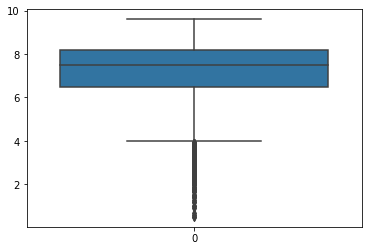

In [9]:
sns.boxplot(data=data_1['User_Score'])

In [10]:
quantile_25=np.quantile(data_1['User_Score'],0.25)
quantile_75=np.quantile(data_1['User_Score'],0.75)
IQR=quantile_75-quantile_25
minimum=quantile_25-1.5*IQR
maximum=quantile_75+1.5*IQR
new_data=data_1[(minimum<=data_1['User_Score'])&(data_1['User_Score']<=maximum)]

<AxesSubplot:>

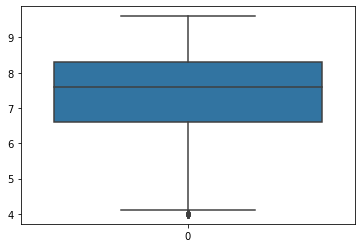

In [11]:
sns.boxplot(data=new_data['User_Score'])

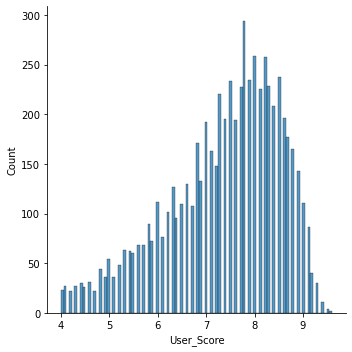

In [13]:
sns.displot(new_data['User_Score'],bins=100)

<AxesSubplot:xlabel='Global_Sales'>

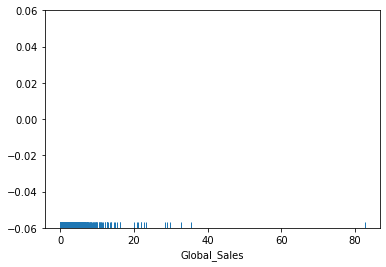

In [14]:
sns.rugplot(new_data['Global_Sales'])

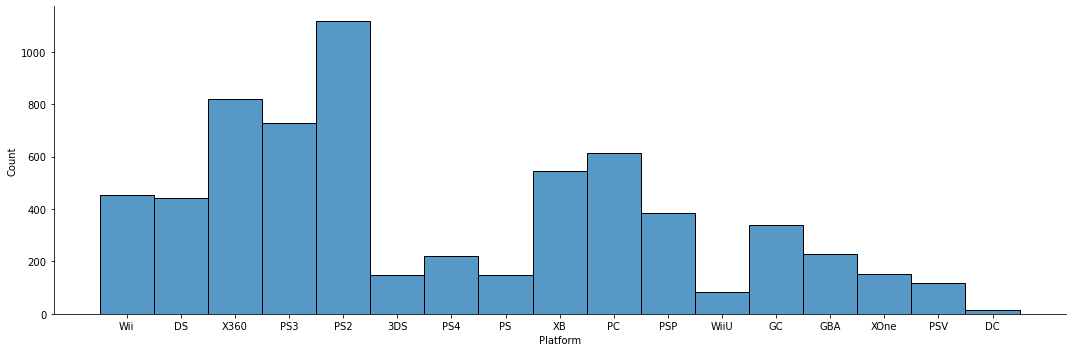

In [15]:
sns.displot(new_data['Platform'],aspect=3)

<AxesSubplot:xlabel='Year_of_Release', ylabel='Count'>

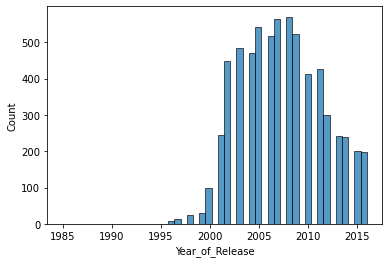

In [16]:
sns.histplot(new_data['Year_of_Release'])

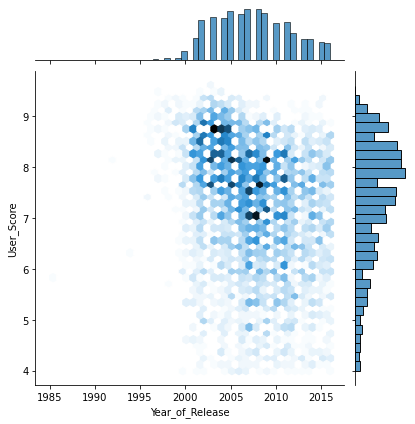

In [17]:
sns.jointplot(x='Year_of_Release', y='User_Score', data=new_data,kind='hex')

In [18]:
new_data=new_data.drop(columns={'Name'})

In [19]:
x=[]
for i in new_data.columns:
    if i=='User_Score':
        continue
    x.append(i)

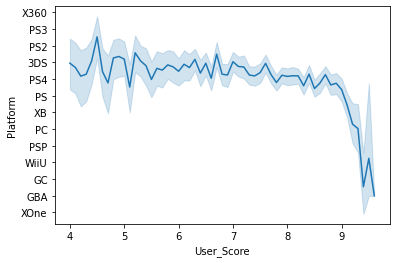

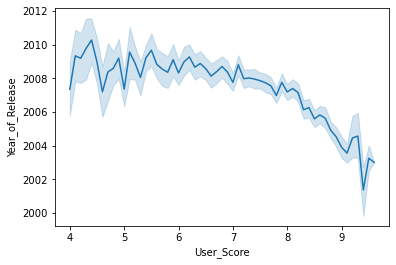

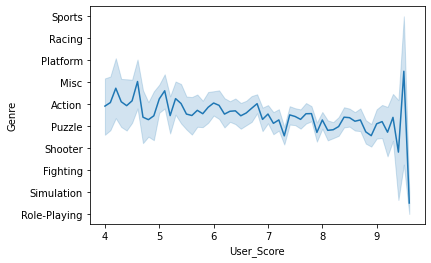

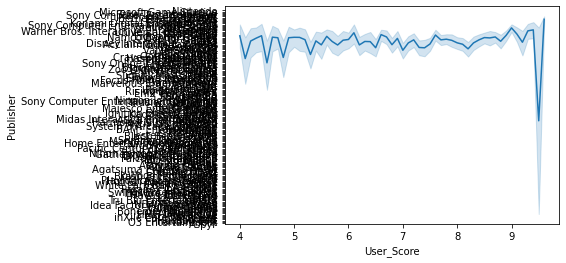

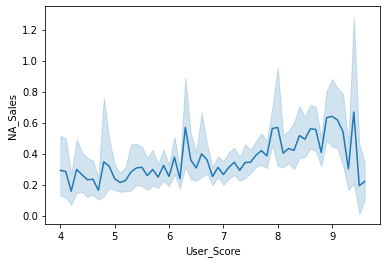

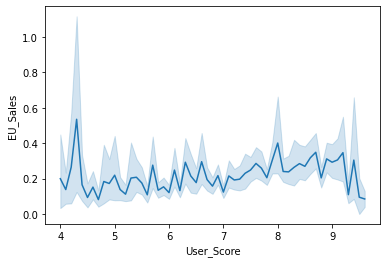

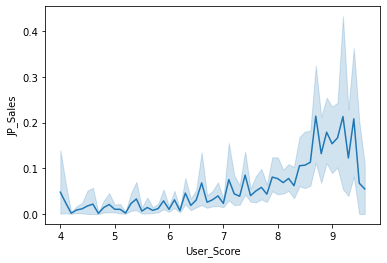

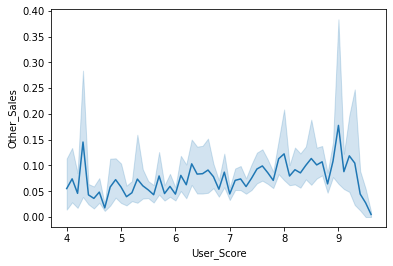

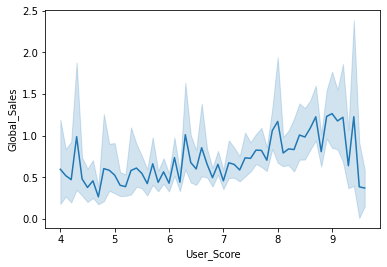

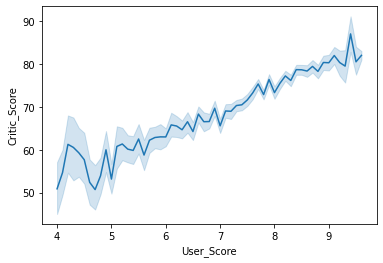

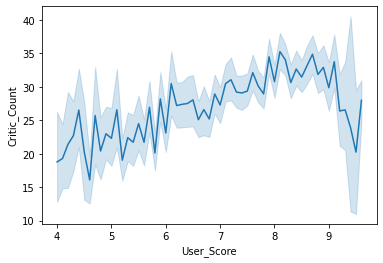

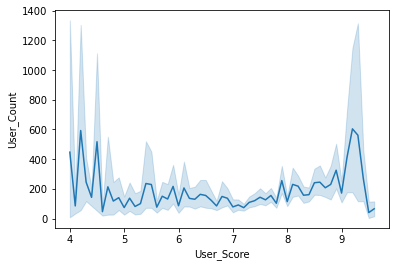

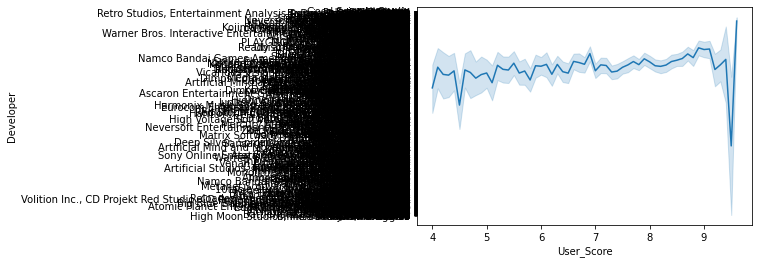

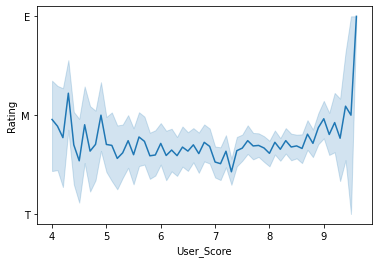

In [20]:
for i in range(len(x)):
    sns.lineplot(x="User_Score",y=x[i],data=new_data)
    plt.show()

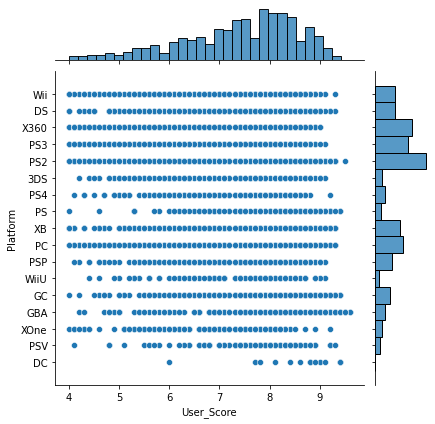

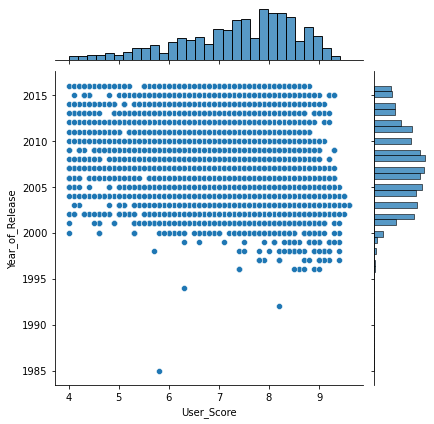

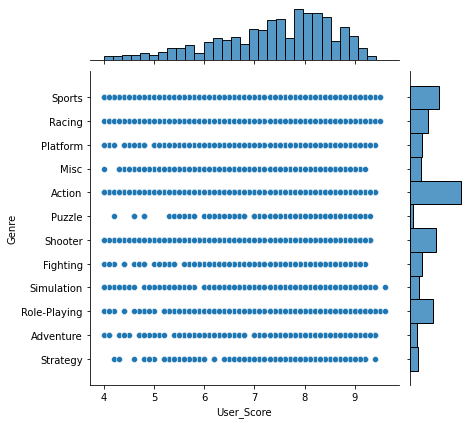

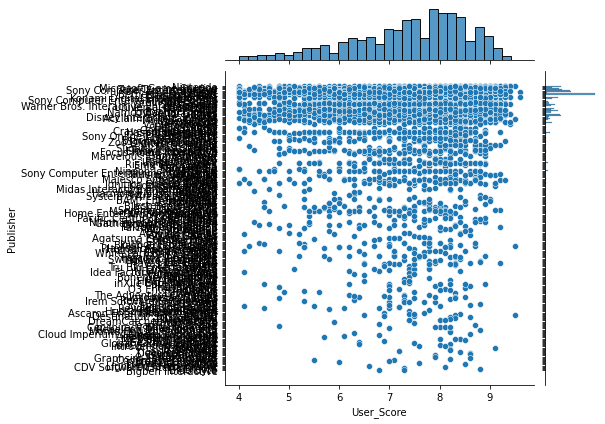

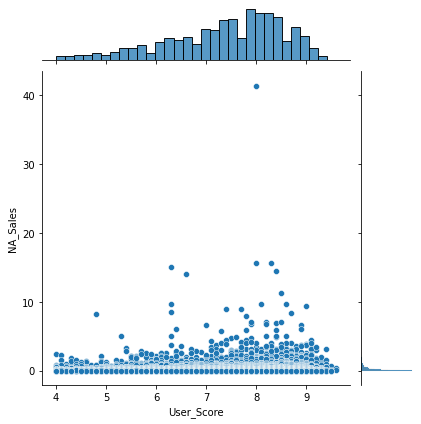

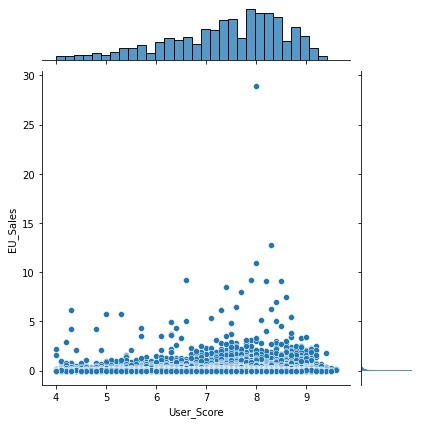

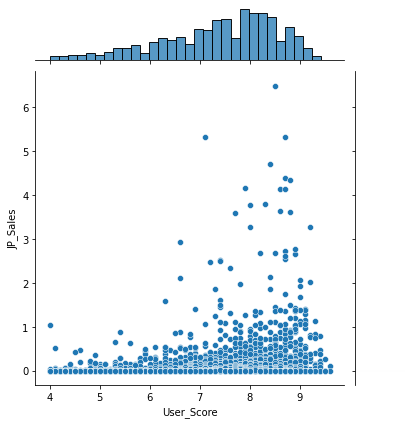

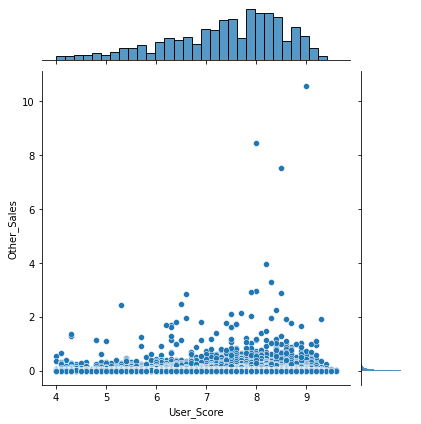

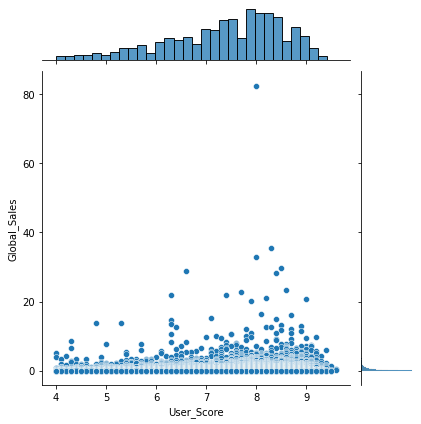

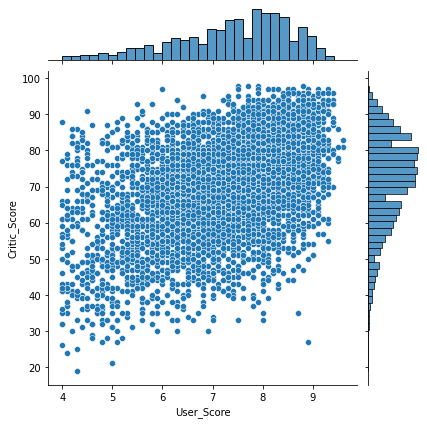

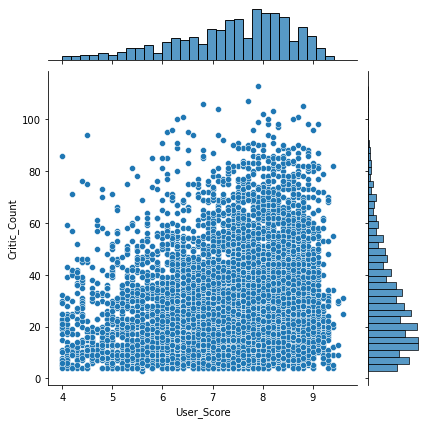

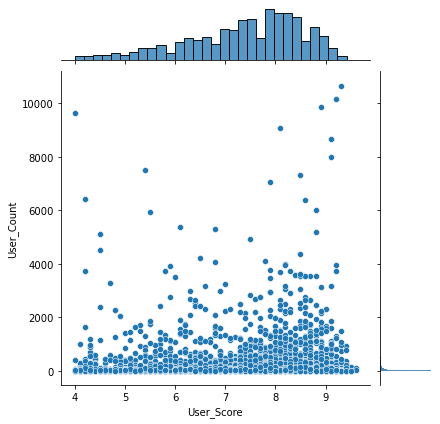

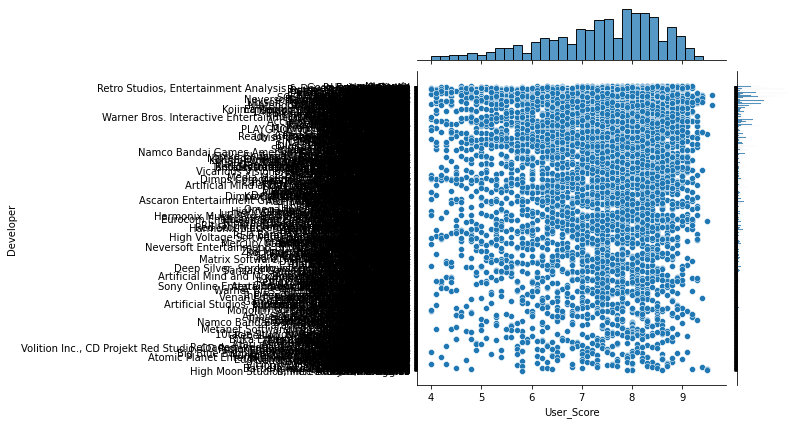

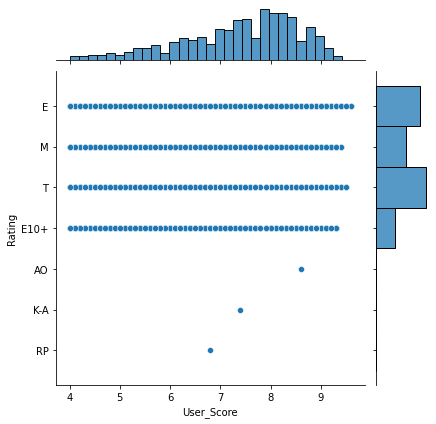

In [21]:
for i in range(len(x)):
    sns.jointplot(x='User_Score',y=x[i],data=new_data)
    plt.show()

<AxesSubplot:>

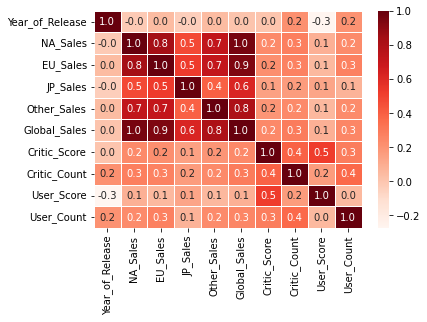

In [22]:
sns.heatmap(data=new_data.corr(),annot=True,fmt='.1f',linewidths=.5,cmap='Reds')


메이플스토리도 있더라

Publisher 중에 NCSoft를 발견해서 찾아보았다.

In [24]:
data_NC=new_data[new_data.Publisher=='NCSoft']

In [25]:
data_NC.head()

,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
688,PC,2012.0,Action,NCSoft,0.96,1.07,0.0,0.27,2.31,90.0,69.0,7.9,2954.0,ArenaNet,T
8658,PC,2014.0,Role-Playing,NCSoft,0.08,0.07,0.0,0.01,0.16,82.0,52.0,7.4,965.0,Carbine Studios,T
14523,PC,2005.0,Role-Playing,NCSoft,0.03,0.00,0.0,0.00,0.03,89.0,53.0,8.4,455.0,ArenaNet,T
14877,PC,2006.0,Role-Playing,NCSoft,0.00,0.02,0.0,0.00,0.03,84.0,30.0,8.7,104.0,ArenaNet,T
16130,PC,2006.0,Role-Playing,NCSoft,0.00,0.01,0.0,0.00,0.01,84.0,39.0,8.5,128.0,ArenaNet,T


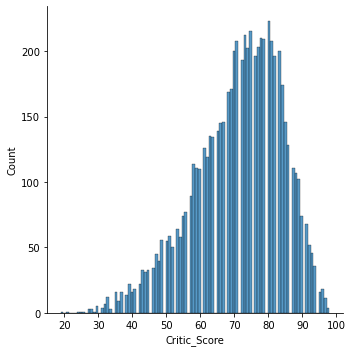

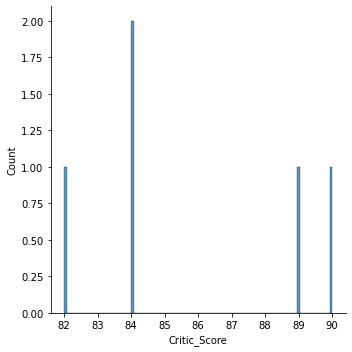

In [26]:
sns.displot(new_data['Critic_Score'],bins=100)
sns.displot(data_NC['Critic_Score'],bins=100)
plt.show()

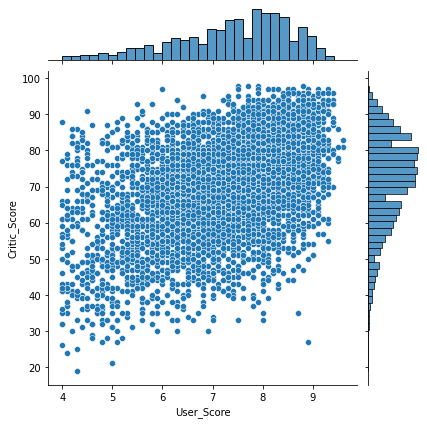

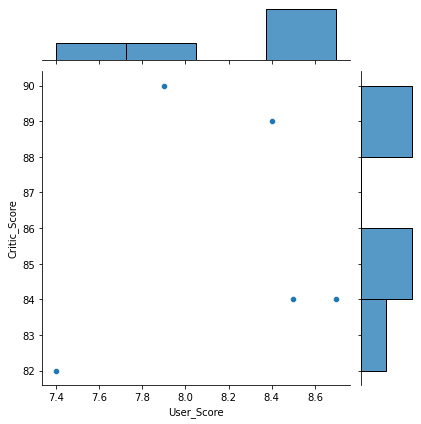

In [27]:
sns.jointplot(x='User_Score',y='Critic_Score',data=new_data)
sns.jointplot(x='User_Score',y='Critic_Score',data=data_NC)
plt.show()

### 1-2. Drop하기전 초기 데이터로 다시 진행하였다.

In [28]:
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [30]:
data[data.Name.isnull()]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
659,NaN,GEN,1993.0,NaN,Acclaim Entertainment,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN,NaN,NaN,NaN
14246,NaN,GEN,1993.0,NaN,Acclaim Entertainment,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN,NaN,NaN,NaN


GEN 에서 Name null값 2개와 Genre null값 2개를 발견했다.

In [31]:
data[data.Platform=='GEN']

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
145,Sonic the Hedgehog 2,GEN,1992.0,Platform,Sega,4.47,1.20,0.16,0.19,6.03,NaN,NaN,NaN,NaN,NaN,NaN
257,Sonic the Hedgehog,GEN,1991.0,Platform,Sega,3.03,0.91,0.26,0.13,4.34,NaN,NaN,NaN,NaN,NaN,NaN
564,Mortal Kombat,GEN,1992.0,Fighting,Arena Entertainment,1.95,0.63,0.00,0.09,2.67,NaN,NaN,NaN,NaN,NaN,NaN
588,Streets of Rage,GEN,1990.0,Action,Sega,1.86,0.55,0.11,0.08,2.60,NaN,NaN,NaN,NaN,NaN,NaN
659,NaN,GEN,1993.0,NaN,Acclaim Entertainment,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN,NaN,NaN,NaN
832,NBA Jam,GEN,1992.0,Sports,Arena Entertainment,1.75,0.25,0.00,0.05,2.05,NaN,NaN,NaN,NaN,NaN,NaN
960,Sonic & Knuckles,GEN,1994.0,Platform,Sega,1.24,0.43,0.03,0.12,1.82,NaN,NaN,NaN,NaN,NaN,NaN
996,Sonic the Hedgehog 3,GEN,1994.0,Platform,Sega,1.02,0.47,0.20,0.07,1.76,NaN,NaN,NaN,NaN,NaN,NaN
1099,Street Fighter II': Special Champion Edition,GEN,1992.0,Fighting,Sega,1.00,0.30,0.31,0.04,1.66,NaN,NaN,NaN,NaN,NaN,NaN
1365,Disney's The Lion King,GEN,1994.0,Platform,Virgin Interactive,0.97,0.37,0.03,0.05,1.41,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data[data.Platform=='GEN']['Genre'].value_counts()

Platform        7
Fighting        5
Action          3
Sports          3
Role-Playing    3
Adventure       2
Racing          1
Strategy        1
Shooter         1
Misc            1
Name: Genre, dtype: int64

In [33]:
data[data.Platform=='GEN']['Genre']=='Platform'

145       True
257       True
564      False
588      False
659      False
832      False
960       True
996       True
1099     False
1365      True
1453     False
1842     False
6452     False
7886     False
8894     False
9001     False
9564     False
9788     False
11564    False
11661    False
11987    False
12099    False
12265    False
12985     True
13344    False
14087    False
14134     True
14246    False
14490    False
Name: Genre, dtype: bool

뒤에 null값도 많고 해서 GEN의 행을 전부 drop했다.

In [34]:
index=data[data['Platform']=='GEN'].index
data_no_GEN=data.drop(index,axis=0)

In [35]:
data_no_GEN.isnull().sum()

Name                  0
Platform              0
Year_of_Release     269
Genre                 0
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8553
Critic_Count       8553
User_Score         6675
User_Count         9100
Developer          6594
Rating             6740
dtype: int64

Year의 Null값을 찾아봤다.

In [36]:
data[data.Year_of_Release.isnull()]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
183,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23,94.0,29.0,8.5,140.0,EA Tiburon,E
377,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49,84.0,20.0,6.4,76.0,EA Canada,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,1.80,0.97,0.00,0.29,3.06,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,1.57,1.02,0.00,0.41,3.00,NaN,NaN,NaN,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,Atari,2.36,0.14,0.00,0.03,2.53,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16376,PDC World Championship Darts 2008,PSP,NaN,Sports,Oxygen Interactive,0.01,0.00,0.00,0.00,0.01,43.0,7.0,tbd,NaN,Oxygen Interactive,E10+
16409,Freaky Flyers,GC,NaN,Racing,Unknown,0.01,0.00,0.00,0.00,0.01,69.0,14.0,6.5,6.0,Midway,T
16452,Inversion,PC,NaN,Shooter,Namco Bandai Games,0.01,0.00,0.00,0.00,0.01,59.0,6.0,6.7,107.0,Saber Interactive,M
16462,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,Unknown,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_year=data_no_GEN[data_no_GEN.Year_of_Release.isnull()]
data_edit=data_no_GEN.drop(data_no_GEN[data_no_GEN.Year_of_Release.isnull()].index)

Year이 null값인 행에서 Name 마지막에 연도가 들어있으면 Null값을 채워주고 나머지는 drop했다.

In [38]:
x=data_year.Name.str.split(" ").str[-1]

In [39]:
data_year.Name.str.split(" ").str[-1]

183           2004
377           2004
456      Videogame
475           2006
609       Invaders
           ...    
16376         2008
16409       Flyers
16452    Inversion
16462        Kitan
16526        Quest
Name: Name, Length: 269, dtype: object

In [40]:
x.str.isdigit()

183       True
377       True
456      False
475       True
609      False
         ...  
16376     True
16409    False
16452    False
16462    False
16526    False
Name: Name, Length: 269, dtype: bool

In [41]:
y=x.tolist()
print(y)

['2004', '2004', 'Videogame', '2006', 'Invaders', 'Band', 'Frog', 'Adventures', '3', 'Band', 'Ops', 'Band', '99', 'Adventure', 'Videogame', 'Combat', '5-7', '2003', 'Assassin', 'Band', 'Reaver', 'III', 'Battle', 'III', '5-7', 'Fortune', '4', '5-7', 'Museum', 'Heaven', 'North', '07', '20-03', 'North', 'Snowboarding', 'Soccer', 'Twisted!', '11', '2', 'Wardrobe', '5-7', '2', 'Substance', '2', 'Ruin', 'Compass', '06', 'Daytona', '2002', 'NY', '2', 'Derby', 'Wet', 'Hedgehog', 'Karate', '07', 'Atari', 'Bay', 'Robbers', 'Homecoming', 'Breakout', 'Conspiracy', 'Slapshot', 'TERA', '2003', '5-7', 'Homeland', 'Conspiracy', 'Homecoming', 'Hangman', 'Compass', '2003', 'Bash', 'sales)', '4', '(2013)', '3', 'Robo', 'XI', 'Singularity', 'Dragster', '2005', 'Outcast', 'Machine', 'Out', 'Towns', '2003', 'Third', 'Island', 'King', 'Conflict', 'Wardrobe', 'Fever', 'sales)', '500', 'Detention', 'Capture', 'Gun', 'Revolution', '5-7', '2K6', 'Challenge', 'Collection', '2', 'Singularity', 'Havoc', 'X20', 'Jam

In [42]:
for i in range(len(y)):
    if y[i].isdigit()==True:
        if(float(y[i])>1900):
            data_year.Year_of_Release.iloc[i]=y[i]
            print(y[i])

2004
2004
2006
2003
2002
2003
2003
2005
2003
2005
2011
2006
2008
2007
2008


C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()


In [43]:
data_year

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
183,Madden NFL 2004,PS2,2004,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.23,94.0,29.0,8.5,140.0,EA Tiburon,E
377,FIFA Soccer 2004,PS2,2004,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.49,84.0,20.0,6.4,76.0,EA Canada,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,1.80,0.97,0.00,0.29,3.06,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
475,wwe Smackdown vs. Raw 2006,PS2,2006,Fighting,NaN,1.57,1.02,0.00,0.41,3.00,NaN,NaN,NaN,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,Atari,2.36,0.14,0.00,0.03,2.53,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16376,PDC World Championship Darts 2008,PSP,2008,Sports,Oxygen Interactive,0.01,0.00,0.00,0.00,0.01,43.0,7.0,tbd,NaN,Oxygen Interactive,E10+
16409,Freaky Flyers,GC,NaN,Racing,Unknown,0.01,0.00,0.00,0.00,0.01,69.0,14.0,6.5,6.0,Midway,T
16452,Inversion,PC,NaN,Shooter,Namco Bandai Games,0.01,0.00,0.00,0.00,0.01,59.0,6.0,6.7,107.0,Saber Interactive,M
16462,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,Unknown,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
data_year.isnull().sum()

Name                 0
Platform             0
Year_of_Release    254
Genre                0
Publisher           22
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       115
Critic_Count       115
User_Score          94
User_Count         142
Developer           80
Rating              88
dtype: int64

In [45]:
data_year=data_year.dropna(axis=0,subset=['Year_of_Release'])

In [46]:
data_sum=pd.concat([data_edit,data_year])

In [47]:
data_sum.isnull().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
Publisher            33
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8442
Critic_Count       8442
User_Score         6585
User_Count         8964
Developer          6518
Rating             6657
dtype: int64

Publisher가 Null값은 drop했다. 데이터에 큰 영향을 주지 않느다고 보였다.

In [48]:
data_sum[data_sum.Publisher.isnull()]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
1667,Shrek / Shrek 2 2-in-1 Gameboy Advance Video,GBA,2007.0,Misc,NaN,0.87,0.32,0.00,0.02,1.21,NaN,NaN,NaN,NaN,NaN,NaN
2212,Bentley's Hackpack,GBA,2005.0,Misc,NaN,0.67,0.25,0.00,0.02,0.93,NaN,NaN,NaN,NaN,NaN,NaN
3148,Nicktoons Collection: Game Boy Advance Video V...,GBA,2004.0,Misc,NaN,0.46,0.17,0.00,0.01,0.64,NaN,NaN,NaN,NaN,NaN,NaN
3159,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,NaN,0.46,0.17,0.00,0.01,0.64,NaN,NaN,NaN,NaN,NaN,NaN
3755,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,NaN,0.38,0.14,0.00,0.01,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4508,The Fairly Odd Parents: Game Boy Advance Video...,GBA,2004.0,Misc,NaN,0.31,0.11,0.00,0.01,0.43,NaN,NaN,NaN,NaN,NaN,NaN
4615,The Fairly Odd Parents: Game Boy Advance Video...,GBA,2004.0,Misc,NaN,0.30,0.11,0.00,0.01,0.42,NaN,NaN,NaN,NaN,NaN,NaN
5633,Cartoon Network Collection: Game Boy Advance V...,GBA,2005.0,Misc,NaN,0.23,0.08,0.00,0.01,0.32,NaN,NaN,NaN,NaN,NaN,NaN
6415,Sonic X: Game Boy Advance Video Volume 1,GBA,2004.0,Misc,NaN,0.19,0.07,0.00,0.00,0.27,NaN,NaN,NaN,NaN,NaN,NaN
6532,Dora the Explorer: Game Boy Advance Video Volu...,GBA,2004.0,Misc,NaN,0.18,0.07,0.00,0.00,0.26,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
data_sum_2=data_sum.drop(data_sum[data_sum.Publisher.isnull()].index)
data_sum_2.isnull().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8410
Critic_Count       8410
User_Score         6555
User_Count         8933
Developer          6488
Rating             6626
dtype: int64

In [50]:
data_sum_2

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,Tour de France 2011,X360,2011,Racing,Focus Home Interactive,0.00,0.04,0.00,0.01,0.05,46.0,7.0,7.6,5.0,Cyanide,NaN
13930,Sega Rally 2006,PS2,2006,Racing,Unknown,0.00,0.00,0.04,0.00,0.04,NaN,NaN,NaN,NaN,NaN,NaN
15955,PDC World Championship Darts 2008,DS,2008,Sports,Unknown,0.01,0.00,0.00,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN
16081,Football Manager 2007,X360,2007,Sports,Sega,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


### 2-2. Critic_Score 이후의 값들을 채움

In [51]:
data_sum_2=data_sum_2.drop(columns={'Name'})

In [52]:
data_sum_3=data_sum_2[data_sum_2.User_Count.isnull()]
data_sum_2=data_sum_2.drop(data_sum_2[data_sum_2.User_Count.isnull()].index)
data_sum_2.isnull().sum()

Platform             0
Year_of_Release      0
Genre                0
Publisher            0
NA_Sales             0
EU_Sales             0
JP_Sales             0
Other_Sales          0
Global_Sales         0
Critic_Score       568
Critic_Count       568
User_Score           0
User_Count           0
Developer           11
Rating              84
dtype: int64

In [53]:
data_sum_4=data_sum_2[data_sum_2.Critic_Score.isnull()]
data_sum_2=data_sum_2.drop(data_sum_2[data_sum_2.Critic_Score.isnull()].index)
data_sum_2.isnull().sum()

Platform            0
Year_of_Release     0
Genre               0
Publisher           0
NA_Sales            0
EU_Sales            0
JP_Sales            0
Other_Sales         0
Global_Sales        0
Critic_Score        0
Critic_Count        0
User_Score          0
User_Count          0
Developer           4
Rating             69
dtype: int64

In [54]:
data_sum_5=data_sum_2[data_sum_2.Rating.isnull()]
data_sum_2=data_sum_2.drop(data_sum_2[data_sum_2.Rating.isnull()].index)
data_sum_2.isnull().sum()

Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64

In [55]:
data_sum_6=pd.concat([data_sum_3,data_sum_4,data_sum_5])
data_sum_6.shape

(9570, 15)

In [57]:
data_sum_6.isnull().sum()

Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8410
Critic_Count       8410
User_Score         6555
User_Count         8933
Developer          6488
Rating             6626
dtype: int64

In [58]:
data_sum_2=data_sum_2.drop(columns={'Publisher'})
data_sum_6=data_sum_6.drop(columns={'Publisher'})

In [59]:
data_sum_2=data_sum_2.astype({'Year_of_Release':'int','User_Score':'float'})

In [60]:
data_sum_2.dtypes

Platform            object
Year_of_Release      int32
Genre               object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object

In [74]:
data_sum_2.shape

(6833, 14)

In [75]:
data_sum_6.shape

(9570, 14)

In [81]:
data_sum_2=data_sum_2.drop(columns={'Platform','Genre'})
data_sum_6=data_sum_6.drop(columns={'Platform','Genre'})

In [84]:
data_sum_2=data_sum_2.drop(columns={'Developer'})
data_sum_6=data_sum_6.drop(columns={'Developer'})

### 3-1. LGBMRegressor을 위해 TrainTestSplit

#### data_sum_2 : OneGotEncoding 하지않은 train 데이터 (6833,14)
#### data_sum_6 ; OneGotEncoding 하지않은 null 데이터 (9570,14)

In [85]:
data_sum_2

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,2006,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,E
2,2008,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,E
3,2009,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,E
6,2006,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,E
7,2006,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...
3486,2002,0.53,0.02,0.00,0.03,0.58,90.0,16.0,8.1,8.0,E
5156,2003,0.31,0.04,0.00,0.01,0.36,82.0,17.0,8.8,6.0,E
5655,2005,0.16,0.12,0.00,0.04,0.32,72.0,13.0,8.6,21.0,E
5889,2003,0.23,0.06,0.00,0.01,0.30,82.0,11.0,8.2,5.0,E


In [86]:
data_sum_6

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
1,1985.0,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN
4,1996.0,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN
5,1989.0,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN
9,1984.0,26.93,0.63,0.28,0.47,28.31,NaN,NaN,NaN,NaN,NaN
10,2005.0,9.05,10.95,1.93,2.74,24.67,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16504,2016.0,0.00,0.00,0.01,0.00,0.01,69.0,13.0,7.5,11.0,NaN
16516,2004.0,0.00,0.01,0.00,0.00,0.01,87.0,6.0,7.2,44.0,NaN
16664,2016.0,0.01,0.00,0.00,0.00,0.01,74.0,13.0,6.7,7.0,NaN
16709,2009.0,0.00,0.01,0.00,0.00,0.01,63.0,6.0,5.8,8.0,NaN


In [93]:
X,test=train_test_split(data_sum_2,test_size=0.2,random_state=0)
X_2=X.drop(columns={'Critic_Score','Rating'})
y=X['Critic_Score']

In [94]:
lgbm_tune=LGBMRegressor()
lgbm_tune.fit(X_2,y)

LGBMRegressor()

In [96]:
X_test=test.drop(columns={'Critic_Score','Rating'})
y_test=test['Critic_Score']
pred = lgbm_tune.predict(X_test)

In [97]:
r2_score(y_test,pred)

0.570818876893703

### 3-2. Critic_Score, Critic_Count, User_Score, User_Count 가 서로 연관성을 가지고 있어 동시에 Null값을 가지는 행을 빼주었다.

Critic_Score =    Critic_Count      User_Score       
Critic_Count  =   Critic_Score     User_Count       
User_Score     =  Critic_Score     
User_Count      = Critic_Count   

In [98]:
CS_index=data_sum_6[data_sum_6.Critic_Score.isnull()].index

In [99]:
CC_index=data_sum_6[data_sum_6.Critic_Count.isnull()].index

In [100]:
US_index=data_sum_6[data_sum_6.User_Score.isnull()].index

In [101]:
UC_index=data_sum_6[data_sum_6.User_Count.isnull()].index

In [106]:
data_sum_7=data_sum_6.drop(CS_index&CC_index&US_index&UC_index)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21300/283876235.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  data_sum_7=data_sum_6.drop(CS_index&CC_index&US_index&UC_index)


In [107]:
data_sum_7

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
119,2010.0,3.45,2.59,0.00,0.66,6.71,NaN,NaN,tbd,NaN,E
182,1997.0,2.30,2.46,0.20,0.28,5.24,85.0,13.0,NaN,NaN,T
301,2005.0,2.08,1.35,0.00,0.54,3.98,61.0,21.0,tbd,NaN,E10+
440,1998.0,2.14,0.86,0.00,0.13,3.12,88.0,13.0,NaN,NaN,E
520,2011.0,1.51,1.03,0.00,0.27,2.81,NaN,NaN,tbd,NaN,T
...,...,...,...,...,...,...,...,...,...,...,...
16504,2016.0,0.00,0.00,0.01,0.00,0.01,69.0,13.0,7.5,11.0,NaN
16516,2004.0,0.00,0.01,0.00,0.00,0.01,87.0,6.0,7.2,44.0,NaN
16664,2016.0,0.01,0.00,0.00,0.00,0.01,74.0,13.0,6.7,7.0,NaN
16709,2009.0,0.00,0.01,0.00,0.00,0.01,63.0,6.0,5.8,8.0,NaN


In [122]:
data_sum_7.dtypes

Year_of_Release      int32
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Rating              object
dtype: object

In [121]:
data_sum_2.dtypes

Year_of_Release      int32
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Rating              object
dtype: object

In [109]:
data_sum_7.User_Score[(data_sum_7['User_Score']=='tbd')]=0

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_21300/3325476541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sum_7.User_Score[(data_sum_7['User_Score']=='tbd')]=0


In [110]:
data_sum_7=data_sum_7.astype({'Year_of_Release':'int','User_Score':'float'})

In [113]:
X,test=train_test_split(data_sum_2,test_size=0.2,random_state=0)
X_2=X.drop(columns={'Critic_Score','Rating'})
y=X['Critic_Score']

In [114]:
lgbm_tune=LGBMRegressor()
lgbm_tune.fit(X_2,y)

LGBMRegressor()

In [117]:
X_test=data_sum_2.drop(columns={'Critic_Score','Rating'})
y_test=data_sum_2['Critic_Score']
pred = lgbm_tune.predict(X_test)

In [118]:
r2_score(y_test,pred)

0.7023068453485533

In [123]:
X_test=data_sum_7.drop(columns={'Critic_Score','Rating'})
pred = lgbm_tune.predict(X_test)

In [124]:
print(pred)

[54.49688521 62.22357596 50.87958855 ... 66.7995591  62.32826203
 61.77748627]


In [125]:
data_sum_7.Critic_Score=pred

Critic_Score 부분이 채워졌고 나머지도 동일하게 진행하면 될것같다.

In [126]:
data_sum_7

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
119,2010,3.45,2.59,0.00,0.66,6.71,54.496885,NaN,0.0,NaN,E
182,1997,2.30,2.46,0.20,0.28,5.24,62.223576,13.0,NaN,NaN,T
301,2005,2.08,1.35,0.00,0.54,3.98,50.879589,21.0,0.0,NaN,E10+
440,1998,2.14,0.86,0.00,0.13,3.12,60.598111,13.0,NaN,NaN,E
520,2011,1.51,1.03,0.00,0.27,2.81,55.364593,NaN,0.0,NaN,T
...,...,...,...,...,...,...,...,...,...,...,...
16504,2016,0.00,0.00,0.01,0.00,0.01,68.407163,13.0,7.5,11.0,NaN
16516,2004,0.00,0.01,0.00,0.00,0.01,66.147669,6.0,7.2,44.0,NaN
16664,2016,0.01,0.00,0.00,0.00,0.01,66.799559,13.0,6.7,7.0,NaN
16709,2009,0.00,0.01,0.00,0.00,0.01,62.328262,6.0,5.8,8.0,NaN
